<a href="https://colab.research.google.com/github/geminiwaldo/CMP419-Weekly-Labs/blob/main/CMP419_lab01_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*The original version of this code was written by me in TensorFlow and converted this year to PyTorch using an LLM, with some manual tweaks and fixes.*

If there is any part of the code you do not understand, please ask in the lab or look it up if you prefer.

# Image classification

We will write up an image classifier using a sequential model and train it from scratch. The baseline model will be a simple one made of a convolution block. The lecture introduced Convolution Neural Networks. This is a nice [interactive visualisation of CNN](https://poloclub.github.io/cnn-explainer/).

A typical vision system will have the same classic Machine Learning steps:
* Data collection and preparation.
* Configuring and training a model and validating its learning by observing learning metrics.
* Evaluating the trained model on test data to assess performance metrics.



# Libraries

Many libraries support the development of machine learning and deep learning models, including TensorFlow/Keras, PyTorch, and fast.ai.

In this module, we use [PyTorch](https://pytorch.org/docs/stable/index.html), an open-source deep learning framework widely adopted in both research and industry. It is the foundation for most cutting-edge deep learning models and libraries in use today, including many state-of-the-art computer vision, language, and multimodal systems. Familiarity with PyTorch is a practical advantage for computing graduates, as it is widely used in contemporary AI development.

We will also import a bunch of other needed packages.


In [1]:
# look up a package if you do not know what it does
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Accelerator

Because deep models are computationally demanding, we will often limit the lab exercises to relatively small datasets for demonstration purposes.
Still, you may want to enable a hardware accelerator [GPU or TPU](https://serverguy.com/comparison/cpu-vs-gpu-vs-tpu/) to avoid long execution time on the CPU. To do this, go to the main menu > Runtime, and change the runtime settings to GPU before executing any code. Keep in mind that if you switch the runtime after running code cells, you will need to restart the runtime, which will reset all progress and variables.

---
**Note: Colab's free tier has limitations on hardware resources and may be denied if used carelessly or unnecessarily. See Lab01.pdf for more information on**
[Colab Policy](https://research.google.com/colaboratory/faq.html)

---
PyTorch does not automatically use your GPU. We must explicitly define a device. By checking `torch.cuda.is_available()`, we ensure the code runs on a GPU if one is present (speeding up training) or falls back to the CPU if not.

In [2]:
# Device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# automatically select the best available hardware
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data

We will use good old MNIST. If you are not familiar with it already, this is a dataset of handwritten digits.
This dataset is automatically downloaded via `torchvision.datasets`. Full list of available datasets is [here](https://docs.pytorch.org/vision/stable/datasets.html).

Let us explore the data briefly. You can perform a more thorough EDA of MNIST in your own time.

In [3]:
# load raw data, no no transformations
raw_train = datasets.MNIST(root="./data", train=True, download=True)
raw_test = datasets.MNIST(root="./data", train=False, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.38MB/s]


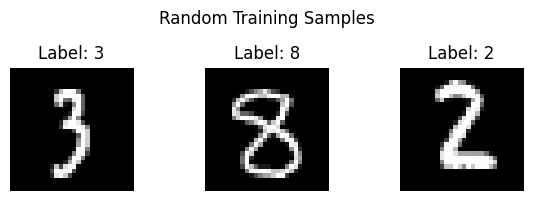

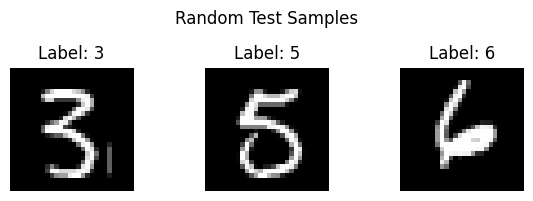

In [4]:
# Function to visualise sample images

def plot_samples(dataset, n_rows=3, n_cols=3, title="Sample Images"):
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
  axes_flat = axes.flatten()

  for ax in axes_flat:
    # Pick a random index between 0 and the end of the dataset
    random_idx = random.randint(0, len(dataset) - 1)

    # Grab the image and label at that specific index
    img, label = dataset[random_idx]

    # Plot
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

# Visualise sample images from both sets
plot_samples(raw_train, 1, 3, title="Random Training Samples")
plot_samples(raw_test, 1, 3, title="Random Test Samples")

Pixel Range: Min 0, Max 255


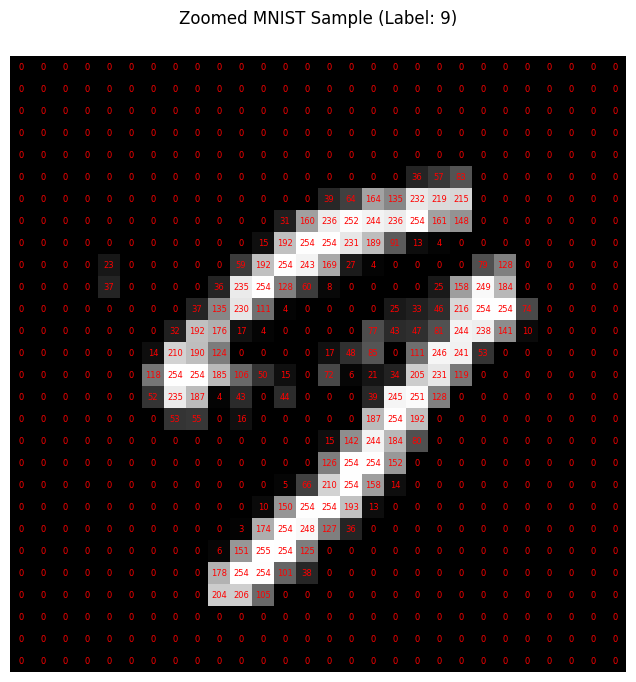

In [5]:
# Let us get a sample to look at closely

# Pick a random index safely
index = random.randint(0, len(raw_train) - 1)

# Get the image and label (raw_train gives PIL Image)
image, label = raw_train[index]

# Convert to numpy array for plotting
sample = np.array(image)  # shape [28, 28]
print(f"Pixel Range: Min {sample.min()}, Max {sample.max()}")

# Set up the plot
plt.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots()
ax.matshow(sample, cmap="gray")

# Annotate each pixel
for i in range(sample.shape[0]):
    for j in range(sample.shape[1]):
        val = sample[i, j]  # note row=i, col=j
        ax.text(j, i, f"{val:.0f}", va='center', ha='center', color="red", fontsize=6)

plt.title(f"Zoomed MNIST Sample (Label: {label})")
plt.axis('off')
plt.show()

## Preprocessing
Before images enter the model, they must be pre-processed using transforms (functions that change the data.)

`ToTensor()` converts the images (which are usually 0-255 pixels) into a Tensor with values between 0.0 and 1.0. It also moves the color channel to the first dimension (e.g., from 28x28x1 to 1x28x28).

`Normalize((0.5,), (0.5,))` scales the pixels so the mean and standard deviation are 0.5. This "centers" the data, which helps the model learn much more stably.

Take a moment to look at `torchvision.transforms` [documentation](https://docs.pytorch.org/vision/stable/transforms.html) to see what other operations you can apply to your data.

In [6]:
# Set tp a transform to apply on the data later
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Data loaders

The `DataLoader` is the engine that feeds data into your model. It handles batching and shuffling. Note that for images, we do not need a `collate_fn` here because transforms already ensured all images are the same size (28x28).

In [7]:
# Split the data into training and testing
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) # apply transforms
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Build a Simple Image Classification Model

This is where we define the Convolutional Neural Network architecture:

`nn.Conv2d` the "eyes" of the model. These layers use filters to scan the image for patterns like edges, curves, or shapes.

`nn.MaxPool2d(2)` reduces the size of the image by half, keeping only the most important (maximum) pixel values. This makes the model faster and less likely to overfit.

`x.view(x.size(0), -1)` is the Flatten step. We take the 2D feature maps from the convolutional layers and unroll them into a long 1D vector so they can be fed into the final classification layers.

-------
This initial model is intentionally simple; there is plenty of room for you to experiment and improve its performance later.

-------


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Reduced filters: only 8
        self.conv1 = nn.Conv2d(1, 8, 3) # convolution layer
        self.pool = nn.MaxPool2d(2)     # max pooling layer
        # 2. Narrow hidden layer
        self.fc1 = nn.Linear(1352, 16)  # fully connected layer 1
        self.fc2 = nn.Linear(16, 10)    # fully connected layer 2
        # other layers could be added for a deeper model

    def forward(self, x):
        x = self.pool(torch.sigmoid(self.conv1(x))) # apply sigmoid activation to conv output
        x = x.view(x.size(0), -1)   # flatten the 2D to 1D
        x = torch.sigmoid(self.fc1(x)) # apply sigmoid activation to output of fc1
        return self.fc2(x) # return output of fc2 (ten scores)

model = SimpleCNN().to(device) # move model to device, if so, data must be too

This is the typical class to define a model in PyTorch. After the model is created, we can look at the layers in sequence and other parameters.


In [9]:
# See the model's structure

# print(model) # quick and dirty

# or

# refined summary
# must provide the input size (Channels, Height, Width)
# for MNIST, that is (1, 28, 28)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
         MaxPool2d-2            [-1, 8, 13, 13]               0
            Linear-3                   [-1, 16]          21,648
            Linear-4                   [-1, 10]             170
Total params: 21,898
Trainable params: 21,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


# Training Setup

Here define our learning hyperparameters. Ideally, we want to  define our Loss Function (how we measure error) and our Optimizer (how we update weights).:

Criterion `nn.CrossEntropyLoss` measures how "wrong" the model is. It is the standard for classification.

Optimizer `optim.Adam` is the algorithm that updates the model's weights. Notice we pass `model.parameters()` so we are explicitly telling the optimizer which weights it is allowed to change.



In [10]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # BASELINE
#optimizer = optim.Adam(model.parameters(), lr=0.1) # MOD 1
#optimizer = optim.SGD(model.parameters(), lr=0.001) # MOD 2

# Training Loop

In PyTorch, we write the loop manually so we can see exactly what happens.

`model.train()` tells the model it is in training mode (important for layers like Dropout).

`optimizer.zero_grad()` is crucial since PyTorch accumulates gradients by default. We must "clear the whiteboard" before calculating the error for a new batch.

`loss.backward()` is the "Backpropagation" step and calculates how much each weight contributed to the error.

`optimizer.step()`is the "Update" step. The optimizer tweaks the weights based on the calculations from the backward pass.


An optional `.to(device)` is added to the loaded images if we moved our model to the GPU (or CPU) earlier. This will move our data to the same device before every calculation. If the model is on the GPU and the data is on the CPU, the code will crash.

In [11]:
# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(5): # on CPU, ~3 min per epoch!! on GPU, seconds..

    model.train(True) # learning mode
    correct, total, running_loss = 0, 0, 0
    start_time = time.time()  # record start time for an epoch


    for images, labels in train_loader: # loop over data batches
        images, labels = images.to(device), labels.to(device)
        # if no device, the data stays on the CPU by default

        optimizer.zero_grad() # clear accumulated gradient
        outputs = model(images) # predict on training data batch

        loss = criterion(outputs, labels) # get error
        loss.backward()  # backpropagate
        optimizer.step() # adjust weights

        # Add the loss of the current batch to a running total
        running_loss += loss.item()
        predictions = outputs.argmax(1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    # metrics per epoch
    end_time = time.time()  # record end time
    epoch_duration = end_time - start_time
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Test stuff ===============================
    model.eval()
    test_correct, test_total, test_running_loss = 0,0,0
    test_start_time = time.time()  # record start time for an epoch

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # clear accumulated gradient
            t_outputs = model(images)
            predictions = t_outputs.argmax(1)

            loss = criterion(t_outputs, labels)

            optimizer.step()

            test_running_loss += loss.item()

            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)

        # metrics per epoch
        #test_end_time = time.time()  # record end time
        #test_epoch_duration = test_end_time - test_start_time
        test_losses.append(test_running_loss / len(test_loader))
        test_accuracies.append(100 * test_correct / test_total)


    print(f"Epoch {epoch+1} | Loss: {train_losses[-1]:.4f} | "
            f"Accuracy: {train_accuracies[-1]:.2f}% | "
            f"Duration: {epoch_duration:.2f}s")

Epoch 1 | Loss: 1.1342 | Accuracy: 75.56% | Duration: 15.57s
Epoch 2 | Loss: 0.4239 | Accuracy: 90.31% | Duration: 14.67s
Epoch 3 | Loss: 0.3089 | Accuracy: 91.77% | Duration: 14.66s
Epoch 4 | Loss: 0.2642 | Accuracy: 92.69% | Duration: 16.42s
Epoch 5 | Loss: 0.2364 | Accuracy: 93.34% | Duration: 15.13s


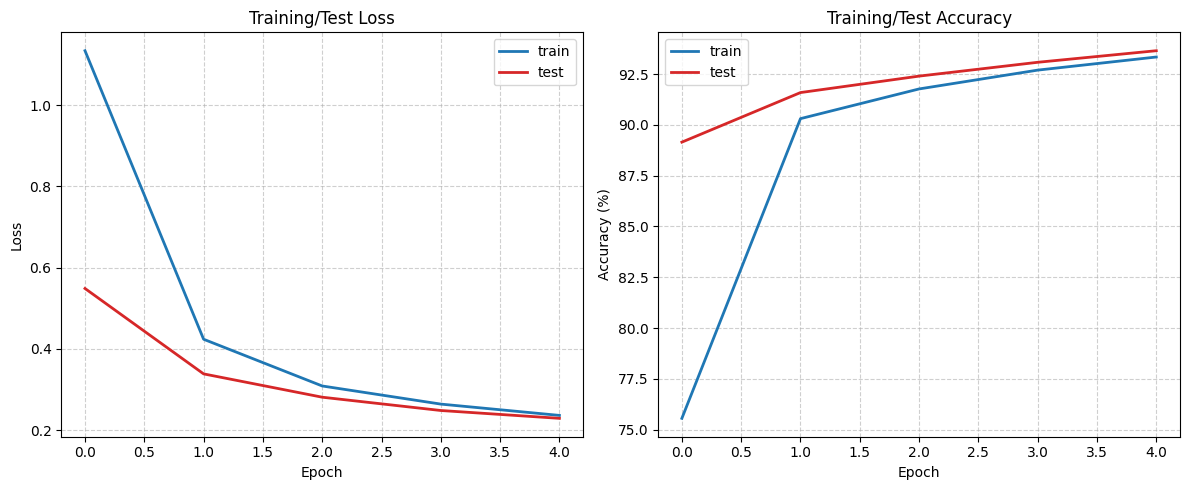

In [12]:
# Create a single figure to hold both plots
plt.figure(figsize=(12, 5))

# Plot 1: Training Loss (1 row, 2 columns, 1st position)
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='tab:blue', linewidth=2, label="train")
plt.plot(test_losses, color='tab:red', linewidth=2, label="test")
plt.title("Training/Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Plot 2: Training Accuracy (1 row, 2 columns, 2nd position)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, color='tab:blue', linewidth=2, label="train")
plt.plot(test_accuracies, color='tab:red', linewidth=2, label="test")
plt.title("Training/Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Adjust layout so labels don't overlap
plt.tight_layout()
plt.show()


# Evaluation

When testing the model, we want to see how it performs on unseen data without changing its weights.

`model.eval()` switches the model to "Evaluation mode." This turns off training-specific behaviors.

`torch.no_grad()` is a memory-saving context manager. It tells `PyTorch` not to bother with calculating gradients or tracking history. We are only doing math to get a prediction, not to learn.




--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.99      0.98      1135
           2       0.93      0.91      0.92      1032
           3       0.91      0.93      0.92      1010
           4       0.95      0.94      0.94       982
           5       0.92      0.89      0.90       892
           6       0.94      0.96      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.91      0.92      0.91       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



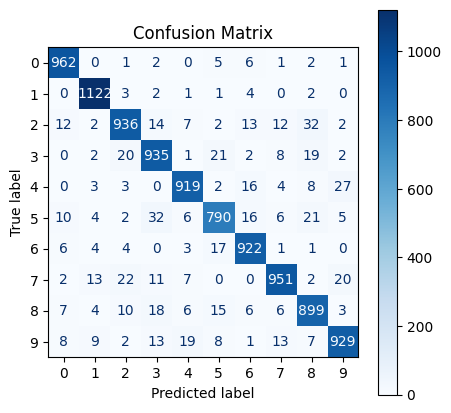


--- Training Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5923
           1       0.94      0.99      0.96      6742
           2       0.94      0.92      0.93      5958
           3       0.92      0.92      0.92      6131
           4       0.94      0.93      0.94      5842
           5       0.93      0.90      0.92      5421
           6       0.94      0.97      0.96      5918
           7       0.95      0.95      0.95      6265
           8       0.93      0.92      0.92      5851
           9       0.93      0.92      0.92      5949

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



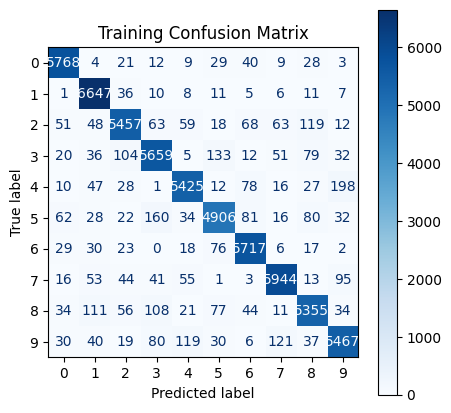

In [13]:
# Set model to evaluation mode
model.eval()
y_true, y_pred = [], []

# Collect predictions
with torch.no_grad():
  for images, labels in test_loader:
    # comment out if model is not on GPU
    images, labels = images.to(device), labels.to(device)

    # Forward pass: get raw model scores
    outputs = model(images)
    # Select the index with the highest score as the prediction
    predictions = outputs.argmax(dim=1)

    # Move results back to CPU and convert to NumPy for evaluation metrics
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Set model to evaluation mode
yt_true, yt_pred = [], []

# Collect predictions
with torch.no_grad():
  for images, labels in train_loader:
    # comment out if model is not on GPU
    images, labels = images.to(device), labels.to(device)

    # Forward pass: get raw model scores
    outputs2 = model(images)
    # Select the index with the highest score as the prediction
    predictions = outputs2.argmax(dim=1)

    # Move results back to CPU and convert to NumPy for evaluation metrics
    yt_true.extend(labels.cpu().numpy())
    yt_pred.extend(predictions.cpu().numpy())

# Classification report
print("\n--- Training Classification Report ---")
print(classification_report(yt_true, yt_pred))

# Confusion matrix plot
cm = confusion_matrix(yt_true, yt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Training Confusion Matrix")
plt.show()

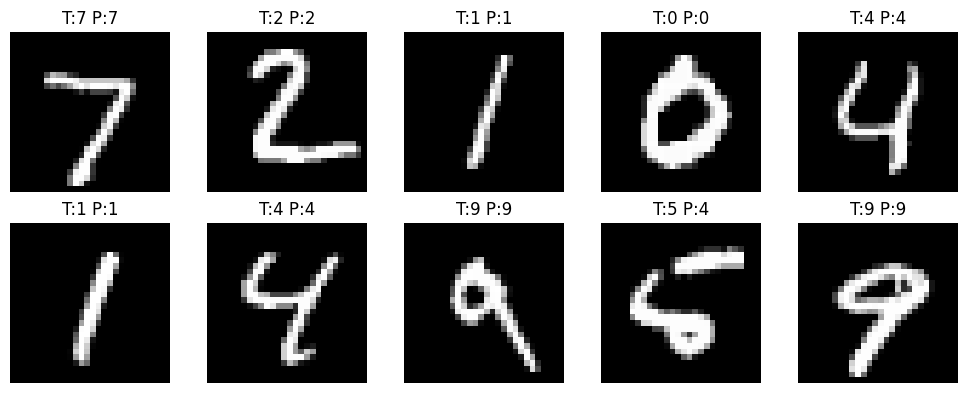

In [14]:
# Visualise some predictions (True vs Predicted)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, (image, label) in zip(axes.flatten(), test_dataset):
    image_tensor = image.unsqueeze(0).to(device)
    pred = model(image_tensor).argmax(1).item()
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"T:{label} P:{pred}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Visualising Feature Maps (optional but useful)

Neural networks are often called "black boxes," but we can actually visualise what the convolutional layers are "seeing." By passing an image through the first layer and capturing its output, we can see how different filters react to edges, curves, and textures.

In `PyTorch`, a Convolutional layer `(nn.Conv2d)` always expects a 4D input: `[Batch, Channels, Height, Width]`. Even if you are only testing a single image, you must pretend it is a "batch of one."

Without the `.unsqueeze(0)` line, the image remains 3D [1, 28, 28].



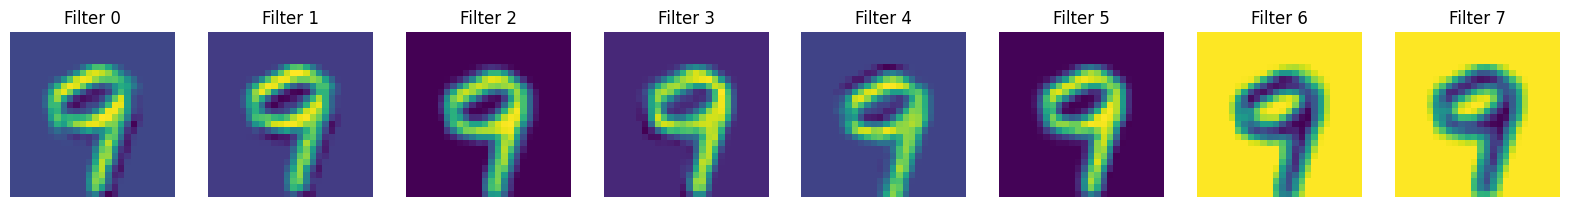

In [15]:
# Pick a random image from the test set, dimension is 3D [1, 28, 28]
index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[index]

# flatten the 3D image into 1D [B, C, H, W] = [1, 1, 28, 28]
image = image.unsqueeze(0).to(device) # add batch dimension and move to device
# if no device, the data stays on the CPU by default

# Pass it through the first convolutional layer
with torch.no_grad():
    feature_maps = model.conv1(image)

# Plot the first 8 filters (feature maps) to see what they detected
fig, ax = plt.subplots(1, 8, figsize=(20, 3))

for i in range(8):
    ax[i].imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
    ax[i].set_title(f'Filter {i}')
    ax[i].axis('off')
plt.show()

The output isn't a single image anymore; it's 32 different versions (since we defined out_channels=32) of the same image, each highlighting a different feature. These are called Feature Maps.
Filter 0 might be highlighting horizontal lines.

Filter 1 might be highlighting vertical edges.

As data goes deeper into the network (e.g., conv2), these simple edges are combined to recognise complex shapes like the loop of a "9" or the crossbar of a "4" like we saw in the lecture.

# Saving and Loading a Trained Model

In PyTorch, the standard practice to saving a model is to save the `state_dict`.
This is simply a Python dictionary that maps each layer to its learnable parameters (weights and biases).
You use `torch.save()`. It is common to use the .pth or .pt file extension.

**Note: this saves the model to as a variable in the notebook (Files tab on the left panel). You must download it manually after that. Alternatively, you could link Colab with your Google Drive and directly save files there there.**


In [ ]:
# Define your file path
save_path = 'simple_cnn_model.pth'

# Save only the weights (recommended)
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

For loading a saved model, because you only saved the weights, you must first have the blueprint (the class) ready before you can load the data into it.

You can set a loaded model with `model.train()` if you want to re-train it, or `model.eval()` if you will be using it for inference.

In [ ]:
# Re-create the model architecture
new_model = SimpleCNN() # you must run that cell if loading a fresh

# Load the saved weights into that architecture
new_model.load_state_dict(torch.load('my_saved_model.pth'))

# Set to evaluation mode if you are doing inference
new_model.eval()

# Predict on samples etc.

# PyTorch Resources


* [Build the Neural Network](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) - read about why we never call the `model.forward` function.
* [Tutorials](https://docs.pytorch.org/tutorials/)
* [Examples](https://github.com/huggingface/transformers/blob/main/examples/pytorch/README.md)
* [fastai](https://course.fast.ai/)


